In [1]:
import scanpy as sc
import pandas as pd
import torch

# Metadata: cell-gene pairs
meta_df = pd.read_csv(
    "/maiziezhou_lab2/yunfei/Projects/interpTFM/activations_cosmx_lung_cancer/gene_ids/shard_0/cell_gene_pairs.txt",
    sep="\t", header=None, names=["cell_id", "gene_id"]
)

# Load your main dataframe
f1_df = pd.read_csv(
    "/maiziezhou_lab2/yunfei/Projects/FM_temp/interGFM/output/test/heldout_top_pairings.csv",
    index_col=0
)
f1_df["concept"] = f1_df["concept"].astype(str).str.strip().str.strip('"')
# Load the file with GO terms
go_df = pd.read_csv("/maiziezhou_lab2/yunfei/Projects/interpTFM/gprofiler_annotation/cosmx_lung_human_gp_go_kegg_reactome.csv", usecols=["term_name", "term_id"])

# Merge: match f1_df['concept'] with go_df['term_name']
f1_df = f1_df.merge(go_df, left_on="concept", right_on="term_name", how="left")

# Activations
###### this is wrong, let's try to use the SAE latents to replace thiss
acts_df = pd.read_parquet("/maiziezhou_lab2/yunfei/Projects/interpTFM/activations_cosmx_lung_cancer/activations/layer_4/shard_0/sae_latents.parquet")


# Load h5ad to get cell types
adata = sc.read_h5ad("/maiziezhou_lab2/yunfei/Projects/FM_temp/InterPLM/interplm/ge_shards/cosmx_human_lung_sec8.h5ad")
celltype_map = adata.obs["author_cell_type"].to_dict()  # dict: cell_id → cell_type

# Add cell_type to meta_df
meta_df["cell_type"] = meta_df["cell_id"].map(celltype_map)

../go-basic.obo: fmt(1.2) rel(2025-07-22) 43,230 Terms
                                             concept     term_id  \
0  positive regulation of vascular associated smo...  GO:1904707   
1  negative regulation of endothelial cell migration  GO:0010596   
2             regulation of DNA biosynthetic process  GO:2000278   
3  regulation of DNA damage response, signal tran...  GO:0043516   
4                                  peptide secretion  GO:0002790   

                                        parent_terms  
0  [biological regulation, positive regulation of...  
1  [negative regulation of cellular process, biol...  
2  [regulation of nucleobase-containing compound ...  
3  [biological regulation, regulation of response...  
4  [transport, establishment of localization, ami...  
[('biological_process', 1581), ('biological regulation', 928), ('regulation of biological process', 893), ('regulation of cellular process', 710), ('cellular process', 378), ('positive regulation of biologi

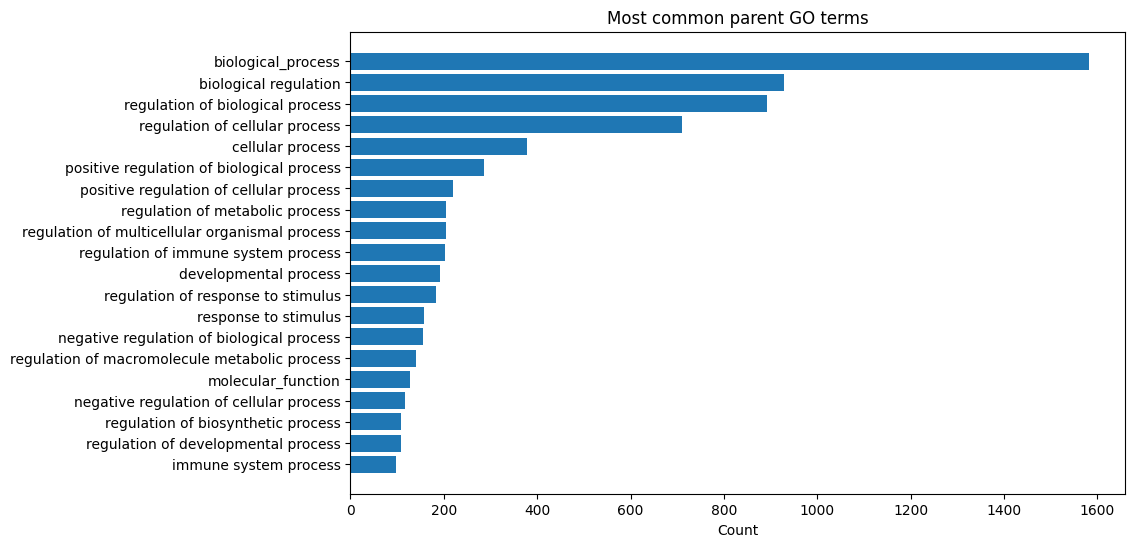

In [3]:
from goatools.obo_parser import GODag

# Load the ontology (download go-basic.obo once)
go_dag = GODag("../go-basic.obo")

def get_parent_terms(go_id, dag):
    if go_id not in dag:
        return []
    term = dag[go_id]
    parents = []
    for parent in term.parents:
        parents.append(parent.name)  # collect parent name in plain English
        parents.extend(get_parent_terms(parent.id, dag))  # recurse
    return list(set(parents))  # unique

# Add parent terms
f1_df["parent_terms"] = f1_df["term_id"].dropna().apply(lambda go: get_parent_terms(go, go_dag))

# Peek
print(f1_df[["concept", "term_id", "parent_terms"]].head())

from collections import Counter
import itertools

# Flatten all parent terms
all_parents = list(itertools.chain.from_iterable(f1_df["parent_terms"].dropna()))
parent_counts = Counter(all_parents)

# Top 20 parent terms
print(parent_counts.most_common(20))

import matplotlib.pyplot as plt

top_n = 20
labels, values = zip(*parent_counts.most_common(top_n))

plt.figure(figsize=(10,6))
plt.barh(labels, values)
plt.gca().invert_yaxis()
plt.title("Most common parent GO terms")
plt.xlabel("Count")
plt.show()


In [5]:
# ============================
# Match best-F1 feature vs GO single-parent label per concept
# Grid-search MAX_DESCENDANTS (+ optional F1_MIN)
# Metrics: ARI & NMI
# ============================

import numpy as np
import pandas as pd
from collections import Counter
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, adjusted_mutual_info_score
from goatools.obo_parser import GODag

# --------------------------------
# Inputs & assumptions
# --------------------------------
# f1_df must have: ['concept','feature','f1','term_id'] (term_id is GO:XXXXXX)
# If not in memory, load it:
# f1_df = pd.read_csv("/path/to/heldout_top_pairings.csv", index_col=0)

GO_OBO_PATH = "../go-basic.obo"   # path to your ontology

# --------------------------------
# Strategy C helpers (same as before)
# --------------------------------
go = GODag(GO_OBO_PATH, load_obsolete=False)

def _descendants_count(term):
    seen = set()
    stack = list(term.children)
    while stack:
        t = stack.pop()
        if t.id not in seen:
            seen.add(t.id)
            stack.extend(t.children)
    return len(seen)

_desc_cache = {}
def descendants_count(go_id):
    if go_id not in go:
        return 0
    if go_id in _desc_cache:
        return _desc_cache[go_id]
    n = _descendants_count(go[go_id])
    _desc_cache[go_id] = n
    return n

def ancestors(go_id):
    if go_id not in go:
        return []
    out, stack = set(), list(go[go_id].parents)
    while stack:
        p = stack.pop()
        if p.id not in out:
            out.add(p.id)
            stack.extend(p.parents)
    return [go[pid] for pid in out if pid in go]

def specific_ancestors(go_id, max_desc):
    keep = []
    for a in ancestors(go_id):
        if descendants_count(a.id) <= max_desc:
            keep.append(a)
    return keep

def term_depth(term):
    return getattr(term, "depth", getattr(term, "level", 0))

# --------------------------------
# One-parent chooser (fewest descendants → deepest → most frequent → ID)
# --------------------------------
def choose_one_parent(parent_terms, freq_by_id):
    if not parent_terms:
        return None
    uniq = {t.id: t for t in parent_terms}.values()
    def score_parent(term):
        return (descendants_count(term.id), -term_depth(term), -freq_by_id[term.id], term.id)
    return min(uniq, key=score_parent)

# --------------------------------
# Build labels
# --------------------------------
def best_f1_feature_per_concept(f1_df, f1_min=None):
    """Return Series: concept -> best feature (argmax f1). Optionally drop concepts with best f1 < f1_min."""
    # pick row with max f1 per concept; break ties by highest f1 then lexical feature
    g = (f1_df.assign(feature=f1_df["feature"].astype(str))
               .sort_values(["concept","f1","feature"], ascending=[True, False, True])
               .groupby("concept", sort=False)
               .head(1))
    if f1_min is not None:
        g = g[g["f1"] >= f1_min]
    return g.set_index("concept")["feature"]

def go_parent_per_concept(f1_df, concepts, max_desc):
    """Return Series: concept -> chosen GO parent name (Strategy C single parent)."""
    term_map = (f1_df.dropna(subset=["term_id"])
                     .groupby("concept")["term_id"]
                     .first()
                     .reindex(concepts))
    parent_sets = []
    all_terms = []
    for go_id in term_map.values:
        if pd.isna(go_id):
            parent_sets.append([])
            continue
        parents = specific_ancestors(str(go_id), max_desc)
        parent_sets.append(parents)
        all_terms.extend(parents)
    if not all_terms:
        return pd.Series(index=concepts, dtype=object)
    freq_by_id = Counter(t.id for t in all_terms)
    chosen = [choose_one_parent(ps, freq_by_id) for ps in parent_sets]
    names = [t.name if t else None for t in chosen]
    return pd.Series(names, index=concepts, dtype=object)

# --------------------------------
# Encode string labels to integers for ARI/NMI
# --------------------------------
def encode_labels(series):
    """Map unique non-null labels to 0..C-1; null stays as NaN to allow intersection filtering."""
    vals = series.dropna().unique().tolist()
    lut = {v:i for i,v in enumerate(sorted(vals))}
    return series.map(lut)

# --------------------------------
# Grid search
# --------------------------------
MAX_DESC_LIST = [50, 150, 300, 400, 500, 750, 1000]
F1_MIN_LIST   = [0.5, 0.75, 0.9]

rows = []
for f1_min in F1_MIN_LIST:
    # F1 labels (no clustering): concept -> best feature
    f1_lab = best_f1_feature_per_concept(f1_df, f1_min=f1_min)
    if f1_lab.empty:
        continue

    # NEW: left-side counts after F1 filtering (before intersecting with GO)
    n_concepts_f1 = int(len(f1_lab))
    n_features_f1 = int(f1_lab.nunique())

    # concept set we’ll evaluate on = those that also have a term_id available (GO side will drop empties anyway)
    eval_concepts = f1_lab.index.tolist()

    for md in MAX_DESC_LIST:
        go_lab = go_parent_per_concept(f1_df, eval_concepts, max_desc=md)

        # Align to concepts having both labels
        mask = (~f1_lab.reindex(eval_concepts).isna()) & (~go_lab.isna())
        if mask.sum() < 2:
            continue

        f1_enc = encode_labels(f1_lab[mask])
        go_enc = encode_labels(go_lab[mask])

        # Right-side/eval counts (after intersecting)
        n_eval_concepts = int(mask.sum())
        n_f1_labels = int(f1_enc.nunique())
        n_go_labels = int(go_enc.nunique())

        # Metrics
        nmi = normalized_mutual_info_score(f1_enc.values, go_enc.values)
        ami = adjusted_mutual_info_score(f1_enc.values, go_enc.values)

        rows.append({
            "f1_min": f1_min if f1_min is not None else -1,
            "max_descendants": md,
            # NEW: left-side (F1) counts after filtering, before intersection with GO
            "n_concepts_f1": n_concepts_f1,
            "n_features_f1": n_features_f1,
            # Existing/eval counts (after intersection)
            "n_eval_concepts": n_eval_concepts,
            "n_f1_labels": n_f1_labels,
            "n_go_labels": n_go_labels,
            # Metrics
            "NMI": float(nmi),
            # "AMI": float(ami),
        })

results = (pd.DataFrame(rows)
           .sort_values(["NMI","n_go_labels"], ascending=[False, False]))
print("Top 12 settings (best match between best-F1 feature vs GO parent):")
print(results.head(12).to_string(index=False))


# --------------------------------
# Inspect the best setting with a confusion table
# --------------------------------
if not results.empty:
    best = results.iloc[0]
    f1_min = None if best["f1_min"] == -1 else float(best["f1_min"])
    md     = int(best["max_descendants"])

    f1_lab = best_f1_feature_per_concept(f1_df, f1_min=f1_min)
    go_lab = go_parent_per_concept(f1_df, f1_lab.index.tolist(), max_desc=md)

    mask = (~f1_lab.isna()) & (~go_lab.isna())
    f1_use = f1_lab[mask]
    go_use = go_lab[mask]

    print(f"\nBest setting details: f1_min={f1_min}, max_descendants={md}, n={mask.sum()}")
    print(f"Unique F1 labels: {f1_use.nunique()}, Unique GO parent labels: {go_use.nunique()}")

    # Confusion (top rows/cols)
    cm = pd.crosstab(go_use, f1_use)  # rows=GO parent, cols=best F1 feature
    # Show the heaviest GO parents
    heavy = cm.sum(axis=1).sort_values(ascending=False).head(20).index
    cm_view = cm.loc[heavy, cm.sum(axis=0).sort_values(ascending=False).head(20).index]
    print("\nConfusion table (top 20x20):")
    print(cm_view)

    # Optional: save full confusion table
    # cm.to_csv(f"confusion_goParent_vs_bestF1_f1min_{f1_min}_maxdesc_{md}.csv")


../go-basic.obo: fmt(1.2) rel(2025-07-22) 43,230 Terms
Top 12 settings (best match between best-F1 feature vs GO parent):
 f1_min  max_descendants  n_concepts_f1  n_features_f1  n_eval_concepts  n_f1_labels  n_go_labels      NMI
   0.90              150             19             15               12           10           12 0.941503
   0.90              300             19             15               14           11           14 0.932350
   0.90              400             19             15               16           12           16 0.926581
   0.90              500             19             15               16           12           16 0.926581
   0.90              750             19             15               16           12           16 0.926581
   0.90             1000             19             15               16           12           16 0.926581
   0.90               50             19             15                9            7            9 0.909091
   0.75               

In [6]:
results

,f1_min,max_descendants,n_concepts_f1,n_features_f1,n_eval_concepts,n_f1_labels,n_go_labels,NMI
15,0.90,150,19,15,12,10,12,0.941503
16,0.90,300,19,15,14,11,14,0.932350
17,0.90,400,19,15,16,12,16,0.926581
18,0.90,500,19,15,16,12,16,0.926581
19,0.90,750,19,15,16,12,16,0.926581
20,0.90,1000,19,15,16,12,16,0.926581
14,0.90,50,19,15,9,7,9,0.909091
7,0.75,50,106,43,41,24,40,0.887953
8,0.75,150,106,43,57,31,54,0.877804
10,0.75,400,106,43,86,39,79,0.848997
